In [173]:
from typing import TypedDict, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, ToolMessage
import os
import requests
from pydantic import BaseModel, Field


load_dotenv()

True

In [174]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

In [175]:
class ToolCaller(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


In [176]:
@tool

def fetch_gitlab_issues():
    """
    Tool to fetch all the open issues in the gitlab.
    """

    GITLAB_URL = "https://gitlab.com/api/v4"
    PROJECT_ID = os.getenv("PROJECT_ID")
    TOKEN = os.getenv("GITLAB_PAT")

    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/projects/{PROJECT_ID}/issues"

    params = {"state": "opened"}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        issues = response.json()
        return [{"iid": i["iid"], "title": i["title"], "state": i["state"],"description": i["description"], "web_url": i["web_url"]} for i in issues]
    else:
        return [{"error": response.text}]

        

In [177]:
@tool

def close_gitlab_issue(issue_iid: str) -> dict:
    """
    Based on the issue ID, the function will help close the open tickets with comment
    """
    GITLAB_URL = "https://gitlab.com/api/v4"
    PROJECT_ID = os.getenv("PROJECT_ID")
    TOKEN = os.getenv("GITLAB_PAT")

    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/projects/{PROJECT_ID}/issues/{issue_iid}"
    data = {"state_event": "close"}

    response = requests.put(url, headers=headers, data=data)

    if response.status_code == 200:
        return {"message": f"Issue #{issue_iid} closed successfully."}
    else:
        return {"error": response.text}


In [178]:
tools = [fetch_gitlab_issues,close_gitlab_issue]

llm_with_tools= gpt_llm.bind_tools(tools)

In [179]:
# def chat_node(state:ToolCaller)-> ToolCaller:
#     """LLM node that may answer or request a tool call"""
    
#     prompt=f"You are an AI assistant who makes different tool calls and provide answers to the users based on user query: {state['messages']}"

#     result=llm_with_tools.invoke(prompt)
#     return {"messages":[result]}

def chat_node(state: ToolCaller) -> ToolCaller:
    """LLM node that handles chat + tool calls."""
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

tool_node= ToolNode(tools)



In [180]:
graph=StateGraph(ToolCaller)
graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node)

graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge("tools","chat_node")


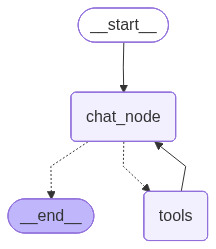

In [181]:
workflow=graph.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [182]:
result=workflow.invoke({"messages":"How many open gitlab tickets do I have?"})

In [183]:
Markdown(result["messages"][-1].content)

You have 2 open GitLab tickets. Here are the details:

1. **Title**: [Langchain retriever not giving right responses](https://gitlab.com/test_gitlab8004948/test_gitlab_2/-/issues/5)
   - **Description**: Langchain retriever not giving the right searches. Need to check if the chunk of documents are ok, or if there's a problem with embedding or something else. RC to be found.

2. **Title**: [Fixing the UI for langgraph persistent chatbot](https://gitlab.com/test_gitlab8004948/test_gitlab_2/-/issues/4)
   - **Description**: Streamlit UI has some bug related to holding the session.

In [184]:
result

{'messages': [HumanMessage(content='How many open gitlab tickets do I have?', additional_kwargs={}, response_metadata={}, id='3b4a066c-d903-42e4-a564-dee9a00b679a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CMLZh7TaPdDCgGlTmzSy2bAh', 'function': {'arguments': '{}', 'name': 'fetch_gitlab_issues'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 91, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTil6LlINkBtNYR3hpXY0TzXt6hDz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--20972ac7-0c94-4460-b6ff-88dbe380338e-0', tool_calls=[{'name': 'fetch_gitlab_issues', 'args': {}, 'id': 'call_CM

In [185]:
#workflow.invoke({"messages":"would you be able to help me close the gitlab issue iid 1?"})

In [186]:
result=workflow.invoke({"messages":"what is tennis?"})

In [187]:
result

{'messages': [HumanMessage(content='what is tennis?', additional_kwargs={}, response_metadata={}, id='84bfb6a6-f1f7-47cd-9d8c-8124af11a37a'),
  AIMessage(content="Tennis is a popular individual or team sport that involves hitting a ball over a net using a racket. It can be played on various surfaces, including grass, clay, and hard courts. The objective of the game is to score points by hitting the ball in such a way that the opponent is unable to return it successfully.\n\nHere are some key points about tennis:\n\n1. **Scoring**: The game is played in sets, where players must win a certain number of games to win a set, and a certain number of sets to win a match. The scoring system includes points, games, and sets, typically counted as 15, 30, 40, and game.\n\n2. **Players**: Tennis can be played as singles (one player against another) or doubles (two players against two players).\n\n3. **Equipment**: Players use a racket to hit a felt-covered rubber ball. The choice of racket can aff

In [188]:
workflow.invoke({"messages":"How many open gitlab tickets do I have?"})

{'messages': [HumanMessage(content='How many open gitlab tickets do I have?', additional_kwargs={}, response_metadata={}, id='e881c227-786f-495e-9305-103c5800eca6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UNPMLVM9cIZNXhciDobBHxcY', 'function': {'arguments': '{}', 'name': 'fetch_gitlab_issues'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 91, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTilMZB4I413qD3Ic0stTnVAcHKbA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1d62e365-9d2c-4a05-9d98-51549a207618-0', tool_calls=[{'name': 'fetch_gitlab_issues', 'args': {}, 'id': 'call_UN